In [1]:
#from mpi4py import MPI 
import netket as nk
import netket.experimental as nkx
import nqs.BeH2_ptutorial as bpm
import pickle
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get data to build the qubit Hamiltonian for BeH2
pauli_list   = np.load('../data/tomography/BeH2/paulis.file',allow_pickle=True)
interactions = np.load('../data/tomography/BeH2/interactions.file',allow_pickle = True)
for k in range(10):
    print('Pauli:',pauli_list[k],' | Interaction: %.3E' % interactions[k])
print('...')

Pauli: IIIIII  | Interaction: -1.707E+01
Pauli: ZIIIII  | Interaction: 1.156E-01
Pauli: XXZIII  | Interaction: 7.270E-03
Pauli: YYIIII  | Interaction: 7.270E-03
Pauli: ZZIIII  | Interaction: 1.000E-01
Pauli: ZXXIII  | Interaction: -4.618E-03
Pauli: IYYIII  | Interaction: -4.618E-03
Pauli: IZZIII  | Interaction: -1.599E-01
Pauli: IIZIII  | Interaction: -3.908E-01
Pauli: IIIZII  | Interaction: 1.156E-01
...


In [49]:
# Define some parameters + get paths to data

N = 6          # Number of qubits
ns = 100000    # Number of training samples
lr = 0.1      # Learning rate
M = 20000      # Number of samples for the negative CD phase
bs = 10000     # Batch size
epochs = 500   # Epochs


samples_path = "../data/tomography/BeH2/train_samples.txt"
bases_path = "../data/tomography/BeH2/train_bases.txt"
pauli_path = "../data/tomography/BeH2/paulis.file"
interactions_path = "../data/tomography/BeH2/interactions.file"
ed_energy = float(np.loadtxt("../data/tomography/BeH2/energy.txt"))
psi0 = np.loadtxt("../data/tomography/BeH2/psi.txt")

In [50]:
psi0

array([-5.81061279e-16,  1.55898334e-17,  2.60173055e-16, -6.34340264e-17,
       -5.27084735e-18, -4.22405947e-16, -4.39571078e-16, -8.53024890e-17,
       -1.40233185e-16,  8.71311245e-03,  1.62174211e-03,  1.40012954e-16,
       -5.64321033e-03,  2.63953129e-16, -4.61694423e-16,  1.87897356e-03,
        7.95891039e-17,  1.62174211e-03, -6.18030936e-02,  5.94663742e-16,
       -2.66801733e-03,  3.70688077e-16,  3.53824630e-16,  4.75449726e-02,
       -5.72155797e-17, -2.49914646e-16, -2.36595855e-16, -2.79809215e-02,
        1.89599335e-15, -5.12492398e-16,  4.19017623e-02, -1.15696469e-16,
       -8.71589307e-16, -5.64321033e-03, -2.66801733e-03, -2.19399394e-15,
        9.89989331e-01,  1.09026373e-16,  5.41641412e-15, -3.19908661e-03,
        3.40740278e-16, -4.22707697e-16,  1.22337899e-16, -1.58246406e-16,
       -2.27298586e-16, -8.60540447e-18, -2.66637460e-16, -4.44007642e-16,
        7.02191571e-17,  3.04821532e-16,  4.35256206e-16,  4.19017623e-02,
       -4.88407380e-15,  

In [51]:
# build rbm + sampler + driver etc -- start with Hamiltonian first

# Hilbert space
hi = nk.hilbert.Qubit(N=6)
# NetKet Hamiltonian
hamiltonian = bpm.BuildHamiltonian(N,hi,pauli_path,interactions_path)

In [52]:
# After building Hamiltonian, check it:
print("\n=== HAMILTONIAN CHECK ===")
print(f"Hamiltonian type: {type(hamiltonian)}")
print(f"Hamiltonian dtype: {hamiltonian.dtype}")

# Try to compute energy on a random state
test_state = np.random.randn(2**N) + 1j * np.random.randn(2**N)
test_state = test_state / np.linalg.norm(test_state)

# Manual energy calculation
H_matrix = hamiltonian.to_dense()  # Get full matrix
test_energy = np.vdot(test_state, H_matrix @ test_state).real
print(f"Test energy on random state: {test_energy}")
print(f"ED ground state energy: {ed_energy}")


=== HAMILTONIAN CHECK ===
Hamiltonian type: <class 'netket.operator._local_operator.jax.LocalOperatorJax'>
Hamiltonian dtype: complex128
Test energy on random state: -17.31330120943592
ED ground state energy: -19.038795049423


In [53]:
# Another check to make sure we can actually get that ground state

# Get the Hamiltonian as a dense matrix
H_matrix = hamiltonian.to_dense()

print("\n=== HAMILTONIAN ANALYSIS ===")
print(f"Hamiltonian shape: {H_matrix.shape}")
print(f"Is Hermitian? {np.allclose(H_matrix, H_matrix.conj().T)}")

# Get eigenvalues + eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
print(f"\nLowest 5 eigenvalues:")
print(eigenvalues[:5])
print(f"Highest 5 eigenvalues:")
print(eigenvalues[-5:])

print(f"\nED ground state energy: {ed_energy}")
print(f"Hamiltonian ground state: {eigenvalues[0]}")

ground_state = eigenvectors[:, 0]
print(f"\nGround state eigenvector shape: {ground_state.shape}")

# get exact ground state and compare with the one they got:
print("Overlap between the gs calculated here and the one they got:",np.dot(ground_state,psi0))


=== HAMILTONIAN ANALYSIS ===
Hamiltonian shape: (64, 64)
Is Hermitian? True

Lowest 5 eigenvalues:
[-19.03879505 -18.57708276 -18.53549258 -18.38773058 -18.38068849]
Highest 5 eigenvalues:
[-15.90826383 -15.64704217 -15.64704217 -15.06263444 -13.72257779]

ED ground state energy: -19.038795049423
Hamiltonian ground state: -19.038795049422998

Ground state eigenvector shape: (64,)
Overlap between the gs calculated here and the one they got: (1.0000000000000007+0j)


In [54]:
# train rbm

# Load training data
rotations, tr_samples, tr_bases = bpm.LoadData(N,hi,samples_path, bases_path)
if (ns > tr_samples.shape[0]):
    "Not enough training samples"
else:
    training_samples = tr_samples[0:ns]
    training_bases   = tr_bases[0:ns]
    
# load bases using new function:
Us = bpm.load_bases(bases_path)

Loaded 128000 measurement bases from ../data/tomography/BeH2/train_bases.txt
Number of qubits: 6
Unique bases: 54


In [55]:
Us[:10]

['ZYYXXZ',
 'ZZXZXZ',
 'XXZZYY',
 'ZZZZZZ',
 'ZXZZXZ',
 'XZZZXZ',
 'ZZZXXZ',
 'XXXZXZ',
 'ZXXZZZ',
 'ZXZZXZ']

In [56]:
U_operators = bpm.BuildBases(hi, Us)

In [57]:
U_operators[:10]

array([LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0.0, dtype=float64),
       LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0.0, dtype=float64)],
      dtype=object)

In [58]:
# RBM wavefunction
ma = nk.models.RBM(alpha=1, param_dtype=complex)        # Complex-weights RBM, alpha=num_hidden/N
# Sampler
sa = nk.sampler.MetropolisLocal(hilbert=hi)

# Optimizer + Stochastic Reconfiguration -- works better but first try SGD
op = nk.optimizer.RmsProp(learning_rate=lr,beta=0.9,epscut = 1.0e-6)
sr = nk.optimizer.SR(diag_shift=0.1)

# Stochastic gradient descent optimizer
# op = nk.optimizer.Sgd(learning_rate=5e-2)

In [59]:
# define the variational state - specifiy the sampler and the model to sample from
vs = nk.vqs.MCState(
    sampler=sa,
    model=ma,
    n_samples=M, 
    seed=42,
)

# let's see it now# Initialize with small random parameters
vs.init_parameters(seed=42)

In [60]:
tr_samples.shape

(128000, 6)

In [61]:
# build a driver to manage the optimisation loop
qst = nkx.QSR(training_data=(tr_samples[:ns],U_operators[:ns]),
              training_batch_size=bs,
              optimizer=op,
              variational_state=vs,
              preconditioner=sr,
              seed=42)

In [62]:
# object to log the details of training 
logger = nk.logging.RuntimeLog()

In [63]:
# # Training loop
fidelity = []
for ep in qst.iter(epochs+1, 10):
    # Get energy measurement
    obs = qst.estimate(hamiltonian) # <psi_lambda|H|psi_lambda>
    # Compute overlap with exact state
    overlap = np.abs(np.vdot(qst.state.to_array(), psi0))
    fidelity.append(overlap**2)
    rbm_energy = obs.mean.real
    print('Epoch = %d   ' % ep,end='')
    print('Fidelity = %.6f   '% fidelity[-1],end='')
    print("<H> = %.8f" % rbm_energy,end=" | ")
    print("ED = %.8f" % ed_energy)

Epoch = 0   Fidelity = 0.014218   <H> = -16.90997381 | ED = -19.03879505
Epoch = 10   Fidelity = 0.066882   <H> = -17.43870917 | ED = -19.03879505
Epoch = 20   Fidelity = 0.050274   <H> = -17.39247231 | ED = -19.03879505
Epoch = 30   Fidelity = 0.048457   <H> = -17.37640214 | ED = -19.03879505
Epoch = 40   Fidelity = 0.040359   <H> = -17.36196170 | ED = -19.03879505
Epoch = 50   Fidelity = 0.071666   <H> = -17.26612301 | ED = -19.03879505
Epoch = 60   Fidelity = 0.031338   <H> = -17.27782411 | ED = -19.03879505
Epoch = 70   Fidelity = 0.023092   <H> = -17.26973198 | ED = -19.03879505
Epoch = 80   Fidelity = 0.025358   <H> = -17.26642790 | ED = -19.03879505
Epoch = 90   Fidelity = 0.044702   <H> = -17.33693574 | ED = -19.03879505
Epoch = 100   Fidelity = 0.026918   <H> = -17.44843584 | ED = -19.03879505
Epoch = 110   Fidelity = 0.040279   <H> = -17.37954287 | ED = -19.03879505
Epoch = 120   Fidelity = 0.033388   <H> = -17.32378155 | ED = -19.03879505
Epoch = 130   Fidelity = 0.044371   

In [64]:
# check that the driver is actually doing the correct estimation

# During training, after an epoch:
obs = qst.estimate(hamiltonian)
rbm_energy = obs.mean.real

# Also compute it manually:
psi_rbm = vs.to_array()  # Get RBM wavefunction
H_matrix = hamiltonian.to_dense()
manual_energy = np.vdot(psi_rbm, H_matrix @ psi_rbm).real / np.vdot(psi_rbm, psi_rbm).real

print(f"qst.estimate energy: {rbm_energy}")
print(f"Manual energy: {manual_energy}")
print(f"RBM norm: {np.linalg.norm(psi_rbm)}")

qst.estimate energy: -17.314025947765675
Manual energy: -17.322045527019597
RBM norm: 1.0


In [65]:
# confirming that psi0 is indeed the ground state
np.vdot(psi0, H_matrix @ psi0).real / np.vdot(psi0, psi0).real

np.float64(-19.038795049422998)

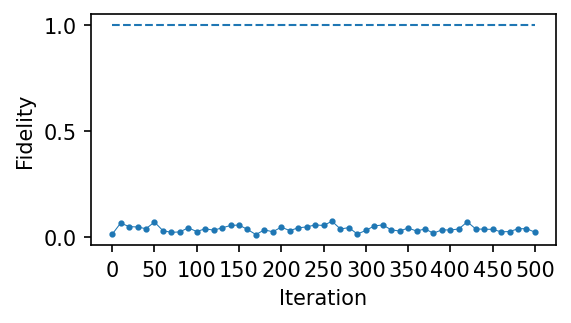

In [66]:
fig = plt.figure(1,figsize=(4,2), dpi=150, facecolor='w', edgecolor='k')

plt.plot(fidelity,linewidth=0.5,marker='o',markersize=2)
plt.xlabel("Iteration",fontsize=10)
plt.ylabel("Fidelity",fontsize=10)
plt.yticks([0.0,0.5,1.0],fontsize=10)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50],[0,50,100,150,200,250,300,350,400,450,500],fontsize=10)
plt.hlines(1.0,xmin=0,xmax = 50,linewidth=1.0,linestyle="--")

plt.show()